# Lab 4: Feature Extraction and Edge detection

Luca Calatroni
luca.calatroni@unige.it

In this notebook, we will:
- Load and visualize a grayscale image.
- Implement simple **finite-difference filters** and a generic 2D convolution in frequency domain for performing derivative-based filtering
- Implement and compare **Sobel** filter.
- Build a simple **LoG (Laplacian of Gaussian)** edge detector using smoothing + Laplacian.
- Use Canny detector testing it also on images with noise.

Project assignment: use Canny edge detector as a pre-processing step, using then the Hough transform do detect circles on a coin image.


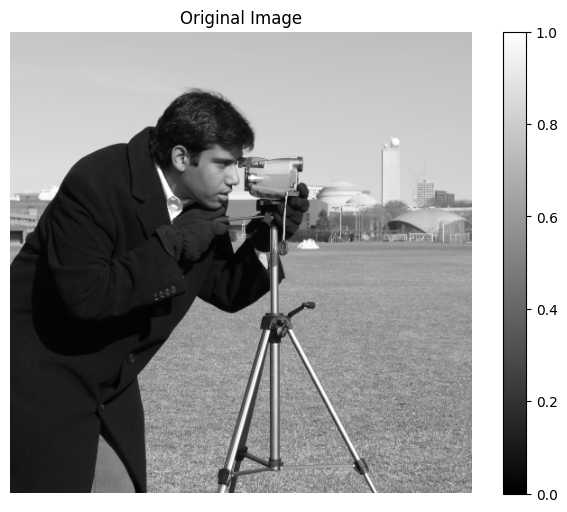

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import fftpack, ndimage
from skimage import data, img_as_float, draw, transform   
from time import perf_counter

# Set default figure size for plots and load sample image

plt.rcParams['figure.figsize'] = (8,6)

img = img_as_float(data.camera())
rows, cols = img.shape

def show(img, title="", cmap='gray'):
    plt.figure()
    plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.colorbar()  
    plt.axis('off')
    plt.show()

show(img, title="Original Image")


## 1. Finite differences and 2D convolution

We start by implementing a simple 2D convolution and using it to build
finite-difference filters. This reinforces the idea that derivative filters
are just convolution kernels.


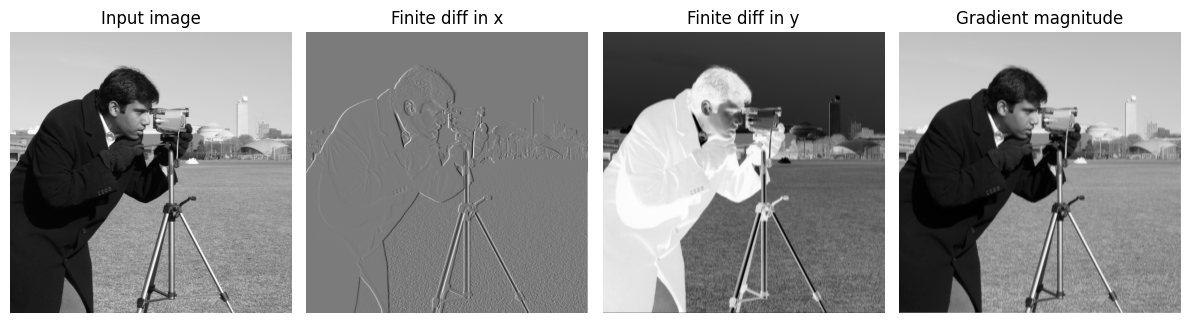

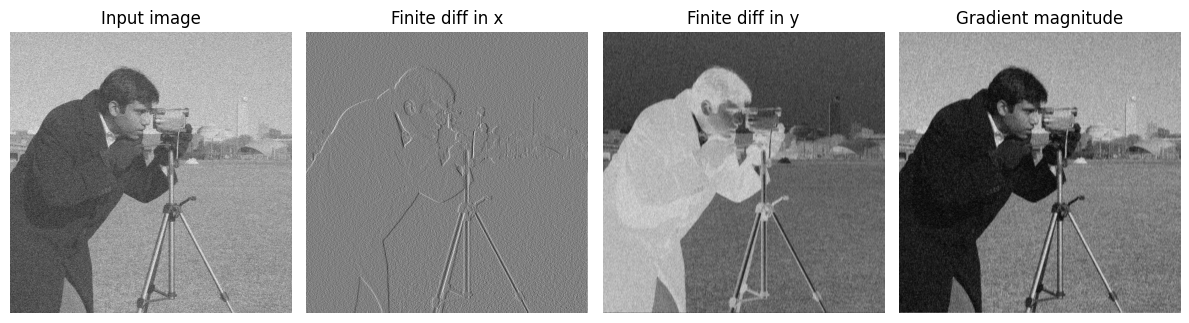

In [34]:
# Same code as last time: convolution via FFT with padding and different modes

def conv2d(img, kernel, pad=(0, 0), mode='reflect'):
    # pad image
    # For 2D arrays, pad_width should be ((top, bottom), (left, right))
    if isinstance(pad, int):
        pad_width = ((pad, pad), (pad, pad))
    else:
        pad_width = ((pad[0], pad[0]), (pad[1], pad[1]))
    
    if mode == 'constant':
        img_pad = np.pad(img, pad_width=pad_width, mode='constant', constant_values=0)
    elif mode == 'reflect':
        img_pad = np.pad(img, pad_width=pad_width, mode='reflect')
    # center-place kernel into padded shape, then ifftshift before FFT
    # This is needed to align the kernel correctly with the padded image for using convolution theorem
    kr, kc = kernel.shape
    ar_shape = img_pad.shape
    ker_centered = np.zeros(ar_shape, dtype=kernel.dtype)
    r0 = (ar_shape[0] - kr) // 2
    c0 = (ar_shape[1] - kc) // 2
    ker_centered[r0:r0+kr, c0:c0+kc] = kernel 
    ker_shifted = fftpack.ifftshift(ker_centered)
    # FFT multiply and inverse
    F_img = fftpack.fft2(img_pad)
    F_k = fftpack.fft2(ker_shifted)
    out_full = np.real(fftpack.ifft2(F_img * F_k))
    # center crop back to original size
    pr = pad_width[0][0]
    pc = pad_width[1][0]
    return out_full[pr:pr+rows, pc:pc+cols]

# Define finite-difference kernels: 
# COMPLETE THIS PART
dx_kernel = np.array([[0, 0, 0],
                    [-0.5, 0, 0.5],
                    [0, 0, 0]], dtype=float)  # horizontal derivative approximated by central difference
dy_kernel = np.array([[0, -0.5, 0],
                    [0, 0, 0],
                    [0, -0.5, 0]], dtype=float) # vertical derivative

pad_x = dx_kernel.shape[0] // 2
pad_y = dx_kernel.shape[1] // 2

gx = conv2d(img, dx_kernel, pad=(pad_x, pad_y), mode='reflect')
gy = conv2d(img, dy_kernel, pad=(pad_y, pad_x), mode='reflect')

# COMPLETE
grad_magnitude = np.sqrt(gx**2 + gy**2)

fig, axes = plt.subplots(1, 4, figsize=(12, 4))
axes[0].imshow(img, cmap='gray')
axes[0].set_title('Input image')
axes[0].axis('off')
axes[1].imshow(gx, cmap='gray')
axes[1].set_title('Finite diff in x')
axes[1].axis('off')
axes[2].imshow(gy, cmap='gray')
axes[2].set_title('Finite diff in y')
axes[2].axis('off')
axes[3].imshow(grad_magnitude, cmap='gray')
axes[3].set_title('Gradient magnitude')
axes[3].axis('off')
plt.tight_layout()
plt.show()

# Now add noise and compute gradients again
np.random.seed(0)
noisy_img = img + 0.1 * np.random.normal(size=img.shape)

gx_noisy = conv2d(noisy_img, dx_kernel, pad=(pad_x, pad_y), mode='reflect')
gy_noisy = conv2d(noisy_img, dy_kernel, pad=(pad_x, pad_y), mode='reflect') 

# COMPLETE
grad_magnitude_noisy = np.sqrt(gx_noisy**2 + gy_noisy**2)

fig, axes = plt.subplots(1, 4, figsize=(12, 4))
axes[0].imshow(noisy_img, cmap='gray')
axes[0].set_title('Input image')
axes[0].axis('off')
axes[1].imshow(gx_noisy, cmap='gray')
axes[1].set_title('Finite diff in x')
axes[1].axis('off')
axes[2].imshow(gy_noisy, cmap='gray')
axes[2].set_title('Finite diff in y')
axes[2].axis('off')
axes[3].imshow(grad_magnitude_noisy, cmap='gray')
axes[3].set_title('Gradient magnitude')
axes[3].axis('off') 
plt.tight_layout()
plt.show()


## 2. Sobel operator

We now implement the **Sobel filters** as convolution kernels.
They combine a smoothing component (weights `[1, 2, 1]`) with a
first-derivative component (e.g. `[-1, 0, 1]`).


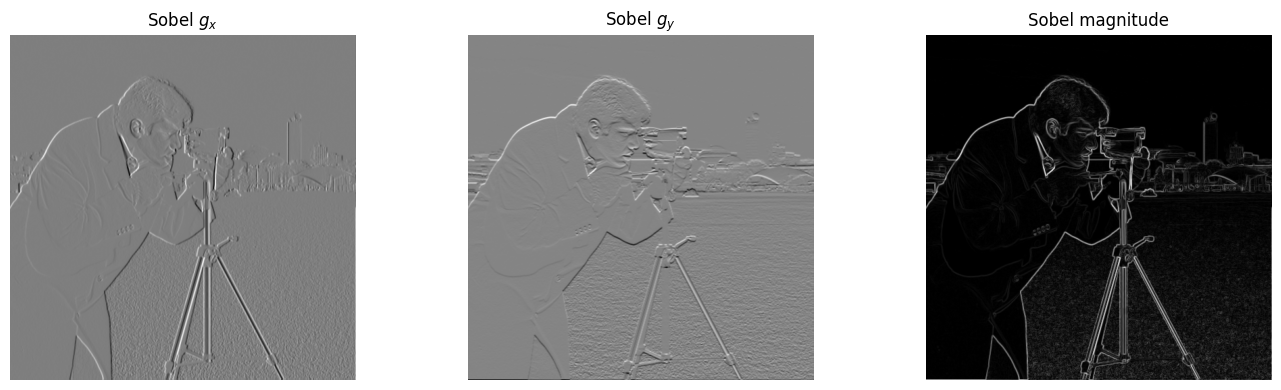

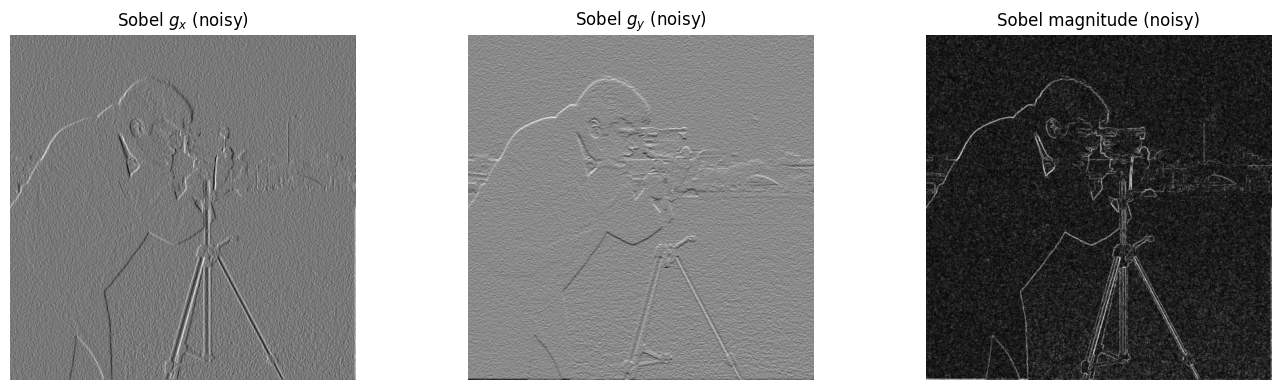

In [35]:
# Sobel kernels
# COMPLETE THIS PART
sobel_x = np.array([[-1, 0, 1],
                    [-2, 0, 2],
                    [-1, 0, 1]], dtype=float)
sobel_y = np.array([[-1, -2, -1],
                    [0, 0, 0],
                    [1, 2, 1]], dtype=float)

gx_sobel = conv2d(img, sobel_x, pad=(pad_x, pad_y), mode='reflect')
gy_sobel = conv2d(img, sobel_y, pad=(pad_x, pad_y), mode='reflect')
# COMPLETE
mag_sobel = np.sqrt(gx_sobel**2 + gy_sobel**2)

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
axes[0].imshow(gx_sobel, cmap='gray')
axes[0].set_title('Sobel $g_x$')
axes[0].axis('off')
axes[1].imshow(gy_sobel, cmap='gray')
axes[1].set_title('Sobel $g_y$')
axes[1].axis('off')
axes[2].imshow(mag_sobel, cmap='gray')
axes[2].set_title('Sobel magnitude')
axes[2].axis('off')
plt.tight_layout()
plt.show()

# Perform the same on noisy image    

gx_sobel_noisy = conv2d(noisy_img, sobel_x)
gy_sobel_noisy = conv2d(noisy_img, sobel_y)
# COMPLETE 
mag_sobel_noisy = np.sqrt(gx_sobel_noisy**2 + gy_sobel_noisy**2)

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
axes[0].imshow(gx_sobel_noisy, cmap='gray')
axes[0].set_title('Sobel $g_x$ (noisy)')
axes[0].axis('off')
axes[1].imshow(gy_sobel_noisy, cmap='gray')     
axes[1].set_title('Sobel $g_y$ (noisy)')
axes[1].axis('off')
axes[2].imshow(mag_sobel_noisy, cmap='gray')
axes[2].set_title('Sobel magnitude (noisy)')
axes[2].axis('off')
plt.tight_layout()
plt.show()  


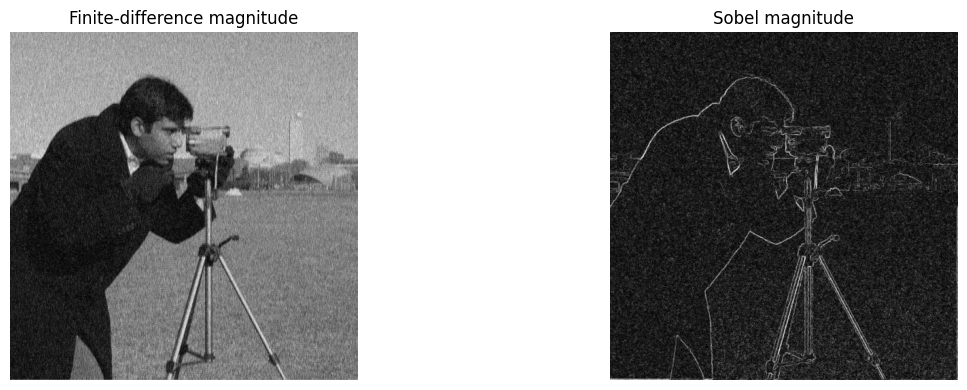

In [36]:
# Comparison between finite-difference and Sobel gradient magnitude on noisy image
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
axes[0].imshow(grad_magnitude_noisy, cmap='gray')
axes[0].set_title('Finite-difference magnitude')
axes[0].axis('off')
axes[1].imshow(mag_sobel_noisy, cmap='gray')
axes[1].set_title('Sobel magnitude')
axes[1].axis('off')
plt.tight_layout()
plt.show()          

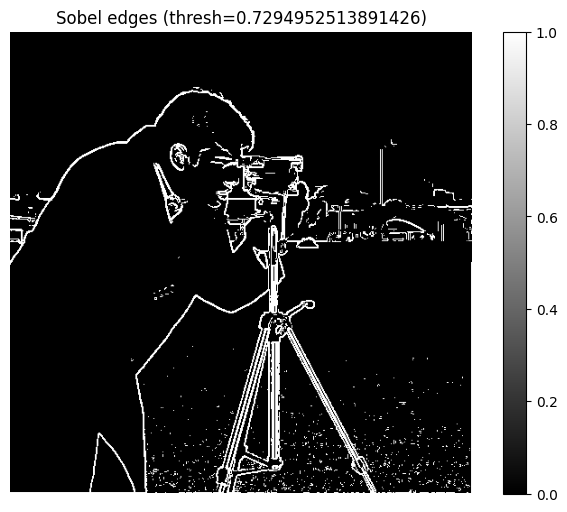

In [37]:
# Fix a threshold and show edges detected by Sobel

# COMPLETE
thresh = 0.2 * np.max(mag_sobel)
edges_sobel = mag_sobel > thresh
show(edges_sobel, title=f'Sobel edges (thresh={thresh})')   

## 3. Laplacian of Gaussian (LoG)

Instead of applying the Laplacia filter directly to the noisy image, we first
smooth the image with a Gaussian and then apply the Laplacian.
This approximates the **LoG operator**.


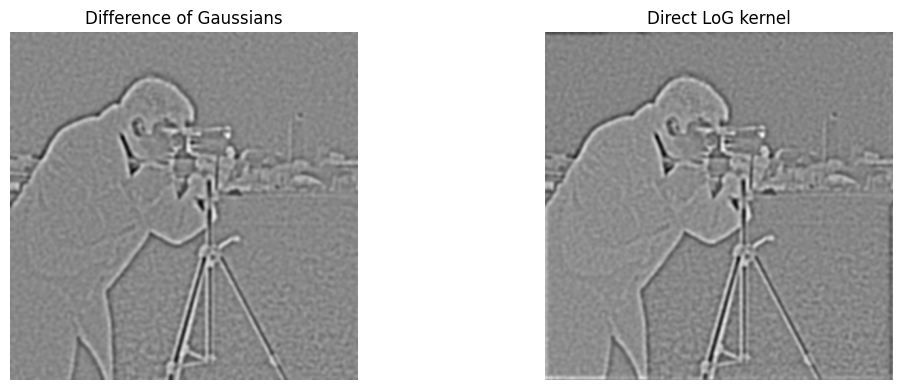

In [38]:
sigma = 3.0
k_size = int(6*sigma)+1  # good kernel size

# Implement the LoG filter directly (formula):
# LoG_sigma(x,y) = -(1/(pi*sigma^4)) * (1 - (x^2+y^2)/(2*sigma^2)) * exp(-(x^2+y^2)/(2*sigma^2))

def laplacian_of_gaussian_kernel(size, sigma):
    ax = np.linspace(-(size//2), size//2, size)
    xx, yy = np.meshgrid(ax, ax)
    log_kernel = -(1/(np.pi*sigma**4)) * (1 - (xx**2 + yy**2)/(2*sigma**2)) * np.exp(-(xx**2 + yy**2)/(2*sigma**2))
    return log_kernel

# Build LoG kernel and apply directly
log_kernel = laplacian_of_gaussian_kernel(k_size, sigma)
log_direct = conv2d(noisy_img, log_kernel, pad=(pad_x, pad_y), mode='reflect')

# Compute LoG as Difference of Gaussians
k=1.05  #scale factor

g1 = ndimage.gaussian_filter(noisy_img, sigma=sigma, mode='reflect')
g2 = ndimage.gaussian_filter(noisy_img, sigma=k*sigma, mode='reflect')
 
dog_response = (g2 - g1) / ((k-1)*sigma)  # Scale normalization


# Compare the two LoG approaches
fig, axes = plt.subplots(1, 2, figsize=(12, 4)) 
axes[0].imshow(dog_response, cmap='gray')
axes[0].set_title('Difference of Gaussians')
axes[0].axis('off')
axes[1].imshow(log_direct, cmap='gray')
axes[1].set_title('Direct LoG kernel')
axes[1].axis('off') 
plt.tight_layout()
plt.show()      


In [39]:
# Compute the difference between the two methods
diff = np.abs(dog_response - log_direct)  
print(f"Max difference between DoG and direct LoG: {diff.max()}")  

Max difference between DoG and direct LoG: 0.08718539422594777


## 4. Canny algorithm 

We can now test a very simple, but effective algorithm: the Canny algorithm for edge detection.

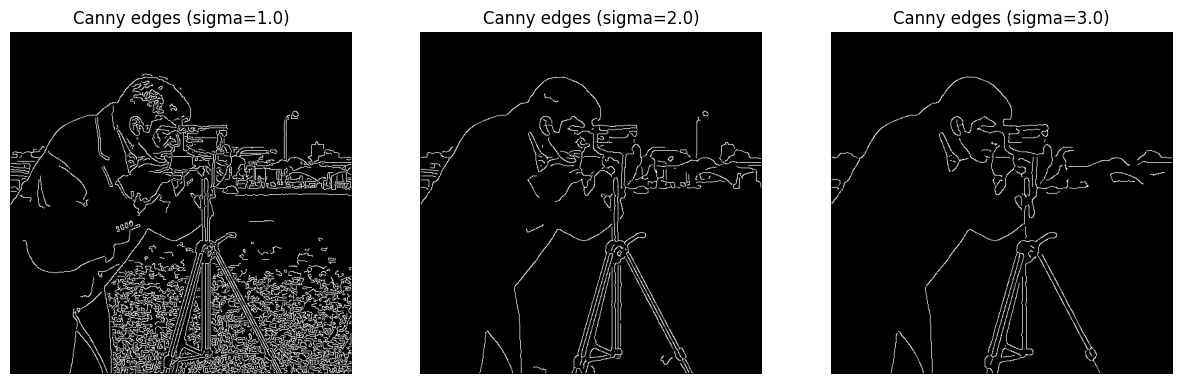

In [41]:
# We now implement Canny's algorithm using also pre-defined functions 
from skimage import feature 

# Let us test different sigma values on the clean image
sigmas = [1.0, 2.0, 3.0]
fig, axes = plt.subplots(1, len(sigmas), figsize=(15, 5))
for ax, s in zip(axes, sigmas):
    edges = feature.canny(img, sigma=s)
    ax.imshow(edges, cmap='gray')
    ax.set_title(f'Canny edges (sigma={s})')
    ax.axis('off')  


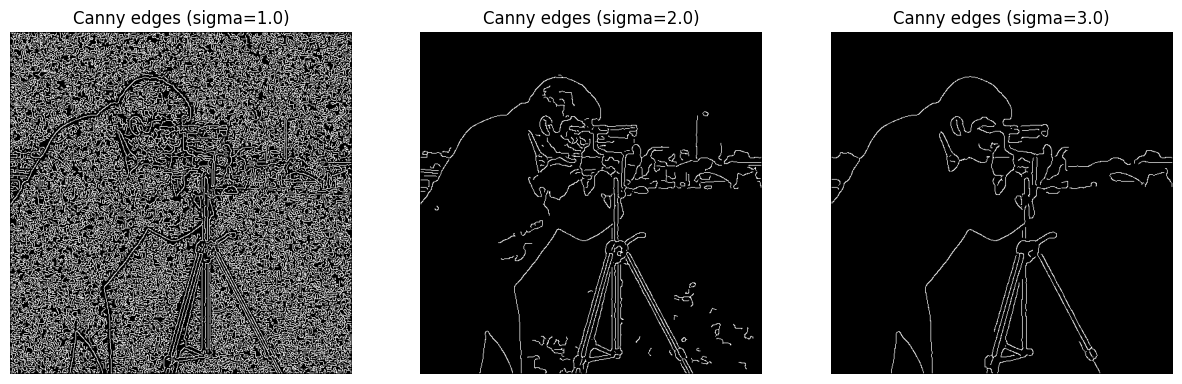

In [42]:
# Let us now test Canny on the noisy image
# COMPLETE: find a good range of sigma values limiting the effect of noise

fig, axes = plt.subplots(1, len(sigmas), figsize=(15, 5))
for ax, s in zip(axes, sigmas):
    edges = feature.canny(noisy_img, sigma=s)
    ax.imshow(edges, cmap='gray')
    ax.set_title(f'Canny edges (sigma={s})')
    ax.axis('off')  
plt.show()


## Project-assignment

Students load the coins image, add Gaussian noise of varying strength, and use the Canny detector as a preprocessing step to produce edge maps suitable for shape detection. They then apply a Circular Hough Transform to detect coin silhouettes, tuning both the Canny thresholds and the Hough radius range to correctly identify individual coins and analyzing how noise and parameter choices affect detection robustness.

In [ ]:
# Let us now consider the Hough transform for circle detection

# Load a sample image with circles
img_circles = img_as_float(data.coins())
show(img_circles, title="Image with Coins (noise-free)") 

# Add some noise of different strengths
np.random.seed(0)
sigma_noise=np.array([0.01, 0.1, 0.2])
noisy_imgs = ....

# Pre-process each noisy image with Canny edge detector with suitable sigma
sigma_canny = ...


In [ ]:

# On each image, perform the Hough Circle Transform for a range of radii
hough_radii = ....  # find a good range of radii
hough_res_list = [transform.hough_circle(edges, hough_radii) for edges in ...]
# For each image, select the most prominent circles
accums = []
cx_list = []
cy_list = []
radii_list = []
num_peaks = 10  # number of circles to detect
for hough_res in hough_res_list:
    centers = []
    accums_img = []
    cx = []
    cy = []
    radii = []
    for radius_idx in range(hough_res.shape[0]):
        # For each radius, extract the Hough accumulator
        hough_acc =...
        # Detect peaks in the Hough accumulator
        peaks = ....
        for peak in peaks:
            # append center coordinates, radius, and accumulator value
            # append accumultator value
            # append y-coordinate of center
            # append x-coordinate of center
            # append radius
    accums.append(accums_img) # append accumulator values for this image
    cx_list.append(cx)
    cy_list.append(cy)
    radii_list.append(radii)    

# Plot detected circles on each noisy image using the function draw.circle_perimeter using the lists cx_list, cy_list, radii_list
for i in range(len(sigma_noise)):       
  ....